### Preparation

In [1]:
bucket = 'sagemaker-frank-hw2'
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference

### Data

In [32]:
# download s3 data to local for processing
import botocore

BUCKET_NAME = 'sagemaker-frank-hw2' # replace with your bucket name
KEY1 = 'FILE_1.csv' # replace with your object key
KEY2 = 'FILE_2.csv'

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY1, 'FILE_1.csv')
    s3.Bucket(BUCKET_NAME).download_file(KEY2, 'FILE_2.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [33]:
training = pd.read_csv('./FILE_2.csv')
pd.set_option('display.max_columns', 5)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
training

,Business_ID,Cuisine,Rating,Num_of_Reviews,Recommended
0,MNNpsRXe7Wt5m3Jla9Wk0w,mexican,5.0,671.0,1
1,VVe74-TKuROBvyS1XgVmvw,mexican,5.0,330.0,1
2,UtknyDJ_DPut-FKRqs0wpQ,indian,5.0,245.0,1
3,AFt1Qcec4_JNr6PWpkRYyw,sushi,5.0,204.0,1
4,3rZwXDjkyDLAHNSdPUI5WA,indian,5.0,166.0,1
5,RfxOtJ4SQmEeVX_XjFLWUQ,american,5.0,163.0,1
6,6tJB7AWwVzccgJdOMWUYkQ,sushi,5.0,143.0,1
7,2UxAkvKkkWNwqZi9H0OzWw,chinese,5.0,131.0,1
8,qoBcWhGwlcUsKIQ2nB22vA,italian,5.0,85.0,1
9,NWHrF-8HC7yIKMXop6n-0Q,american,5.0,84.0,1


In [34]:
list(training)

['Business_ID', 'Cuisine', 'Rating', 'Num_of_Reviews', 'Recommended']

In [61]:
testing = pd.read_csv('./FILE_1.csv')
testing

,Business_ID,Cuisine,Rating,Num_of_Reviews
0,wobICp6lQP7Y6dfnJ_4Ujw,chinese,2.5,439.0
1,lynQoI3w_pzYfHGeuUU-Qg,chinese,4.5,650.0
2,_XLLSXPIjgoZQtwU3RCcQA,chinese,4.0,274.0
3,0CjK3esfpFcxIopebzjFxA,chinese,4.0,5672.0
4,X8ZS-dgiMIJvhwf9SaDnjw,chinese,4.5,1152.0
5,wfhMIiMh2A2psCGONOVSlg,chinese,4.0,1109.0
6,xH7mEjh4Rn6KdHjXYNoOjw,chinese,3.5,684.0
7,xq0cX_DgxiJMXwhmEl9kUA,chinese,4.0,1368.0
8,FXhSEZfIqjMZh4hR0_8jMQ,chinese,4.0,371.0
9,vZgJyMZlpSSS_Y-duxd4_A,chinese,4.0,259.0


In [36]:
# data transformation: drop id, transform categorical cuisine column to numerical 
training = training.drop(['Business_ID'], axis=1)

In [37]:
list(training)

['Cuisine', 'Rating', 'Num_of_Reviews', 'Recommended']

In [38]:
training = pd.get_dummies(training)                                                          

In [44]:
list(training)

['Rating',
 'Num_of_Reviews',
 'Recommended',
 'Cuisine_american',
 'Cuisine_chinese',
 'Cuisine_indian',
 'Cuisine_italian',
 'Cuisine_mexican',
 'Cuisine_sushi']

In [45]:
# Note that the first column must be the target variable and the CSV should not include headers
training = pd.concat([training['Recommended'], training.drop(['Recommended'], axis=1)], axis=1)

In [46]:
training

,Recommended,Rating,...,Cuisine_mexican,Cuisine_sushi
0,1,5.0,...,1,0
1,1,5.0,...,1,0
2,1,5.0,...,0,0
3,1,5.0,...,0,1
4,1,5.0,...,0,0
5,1,5.0,...,0,0
6,1,5.0,...,0,1
7,1,5.0,...,0,0
8,1,5.0,...,0,0
9,1,5.0,...,0,0


In [47]:
training.to_csv('train.csv', index=False, header=False)

In [48]:
boto3.Session().resource('s3').Bucket(bucket).Object('train.csv').upload_file('train.csv')

In [62]:
testing_bid = testing['Business_ID']                                                        

In [64]:
testing = testing.drop(['Business_ID'], axis=1)

In [65]:
testing = pd.get_dummies(testing)                                                          

In [68]:
testing

,Rating,Num_of_Reviews,...,Cuisine_mexican,Cuisine_sushi
0,2.5,439.0,...,0,0
1,4.5,650.0,...,0,0
2,4.0,274.0,...,0,0
3,4.0,5672.0,...,0,0
4,4.5,1152.0,...,0,0
5,4.0,1109.0,...,0,0
6,3.5,684.0,...,0,0
7,4.0,1368.0,...,0,0
8,4.0,371.0,...,0,0
9,4.0,259.0,...,0,0


### Training

In [49]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [52]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/train.csv'.format(bucket), content_type='csv')

In [54]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/output'.format(bucket),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=50)

xgb.fit({'train': s3_input_train}) 

INFO:sagemaker:Creating training-job with name: xgboost-2019-04-05-03-15-31-305


2019-04-05 03:15:31 Starting - Starting the training job...
2019-04-05 03:15:33 Starting - Launching requested ML instances......
2019-04-05 03:16:36 Starting - Preparing the instances for training......
2019-04-05 03:17:54 Downloading - Downloading input data
2019-04-05 03:17:54 Training - Downloading the training image..
Arguments: train
[2019-04-05:03:18:13:INFO] Running standalone xgboost training.
[2019-04-05:03:18:13:INFO] Path /opt/ml/input/data/validation does not exist!
[2019-04-05:03:18:13:INFO] File size need to be processed in the node: 0.0mb. Available memory size in the node: 8411.61mb
[2019-04-05:03:18:13:INFO] Determined delimiter of CSV input is ','
[03:18:13] S3DistributionType set as FullyReplicated
[03:18:14] 200x8 matrix with 1600 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[03:18:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]#011train-error:0
[03:18:14] src/tree/upd

### Hosting and Prediction

In [55]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-04-05-03-20-05-202
INFO:sagemaker:Creating endpoint with name xgboost-2019-04-05-03-15-31-305


---------------------------------------------------------------------------!

In [72]:
xgb_predictor.serializer = csv_serializer

In [73]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

predictions = predict(testing.as_matrix())

In [76]:
predictions

array([0.07493605, 0.92555648, 0.92555648, ..., 0.07493605, 0.92555648,
       0.92555648])

(array([1826.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 3552.]),
 array([0.07493605, 0.13569466, 0.19645326, 0.25721186, 0.31797046,
        0.37872906, 0.43948767, 0.50024627, 0.56100487, 0.62176347,
        0.68252207, 0.74328068, 0.80403928, 0.86479788, 0.92555648]),
 <a list of 14 Patch objects>)

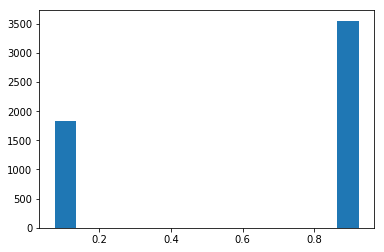

In [81]:
plt.hist(predictions, bins='auto')  # arguments are passed to np.histogram

In [77]:
testing_original = pd.read_csv('./FILE_1.csv')

In [78]:
testing_original

,Business_ID,Cuisine,Rating,Num_of_Reviews
0,wobICp6lQP7Y6dfnJ_4Ujw,chinese,2.5,439.0
1,lynQoI3w_pzYfHGeuUU-Qg,chinese,4.5,650.0
2,_XLLSXPIjgoZQtwU3RCcQA,chinese,4.0,274.0
3,0CjK3esfpFcxIopebzjFxA,chinese,4.0,5672.0
4,X8ZS-dgiMIJvhwf9SaDnjw,chinese,4.5,1152.0
5,wfhMIiMh2A2psCGONOVSlg,chinese,4.0,1109.0
6,xH7mEjh4Rn6KdHjXYNoOjw,chinese,3.5,684.0
7,xq0cX_DgxiJMXwhmEl9kUA,chinese,4.0,1368.0
8,FXhSEZfIqjMZh4hR0_8jMQ,chinese,4.0,371.0
9,vZgJyMZlpSSS_Y-duxd4_A,chinese,4.0,259.0


In [79]:
testing_original['score'] = predictions

In [80]:
testing_original

,Business_ID,Cuisine,Rating,Num_of_Reviews,score
0,wobICp6lQP7Y6dfnJ_4Ujw,chinese,2.5,439.0,0.074936
1,lynQoI3w_pzYfHGeuUU-Qg,chinese,4.5,650.0,0.925556
2,_XLLSXPIjgoZQtwU3RCcQA,chinese,4.0,274.0,0.925556
3,0CjK3esfpFcxIopebzjFxA,chinese,4.0,5672.0,0.925556
4,X8ZS-dgiMIJvhwf9SaDnjw,chinese,4.5,1152.0,0.925556
5,wfhMIiMh2A2psCGONOVSlg,chinese,4.0,1109.0,0.925556
6,xH7mEjh4Rn6KdHjXYNoOjw,chinese,3.5,684.0,0.074936
7,xq0cX_DgxiJMXwhmEl9kUA,chinese,4.0,1368.0,0.925556
8,FXhSEZfIqjMZh4hR0_8jMQ,chinese,4.0,371.0,0.925556
9,vZgJyMZlpSSS_Y-duxd4_A,chinese,4.0,259.0,0.925556


In [83]:
testing_original.to_csv('testing.csv', index=False, header=True)

In [84]:
boto3.Session().resource('s3').Bucket(bucket).Object('FILE_3.csv').upload_file('testing.csv')